In [1]:
from src.functions import *

In [2]:
def magnetization(H, T):
    d = len(H)
    n = int(np.log2(d))
    mag_basis = np.zeros(d)
    for i in range(d):
        s = int_to_bin(i, n)
        mag_basis[i] = (s.count('0') - s.count('1')) / n
    E, vecs = la.eigh(H)
    if T == 0:
        boltzmann_factors = np.array(E == min(E), dtype=int) / sum(np.array(E == min(E), dtype=int))
    else:
        boltzmann_factors = scipy.special.softmax(-E / T)
    mag = 0
    for i, vec in enumerate(vecs.T):
        mag += mag_basis @ vec**2 * boltzmann_factors[i]
    return mag

In [3]:
def qea(H, T):
    '''Edward-Anderson parameter'''
    d = len(H)
    n = int(np.log2(d))
    E, vecs = la.eigh(H)
    if T == 0:
        boltzmann_factors = np.array(E == min(E), dtype=int) / sum(np.array(E == min(E), dtype=int))
    else:
        boltzmann_factors = scipy.special.softmax(-E / T)

    qea = 0
    for i in range(n):
        sigma_i = Z(i, n)
        s = 0
        for vec_index, vec in enumerate(vecs.T):
            s += vec @ sigma_i @ vec.T * boltzmann_factors[vec_index]
        qea += s**2

    return qea / n

In [4]:
n = 4
num_random_models = 100

gamma_lims = (0,1) 
gamma_steps = 50
T_lims = (1e-2,1e2)
T_steps = 50

gamma_range = np.linspace(gamma_lims[0], gamma_lims[1], gamma_steps)
T_range = np.geomspace(T_lims[0], T_lims[1], T_steps)

In [5]:
def f_mag(T):
    mag = np.zeros((gamma_steps, num_random_models))
    for gamma_id, gamma in enumerate(gamma_range):
        np.random.seed(0) # set the seed for reproducibility
        for i in range(num_random_models):
            m = RandomIsingModel(n, local_fields=True)
            H_ising = np.diag(m.E_rescaled)
            H_mixer = H_mixer_list[m.n-1]
            H = (1-gamma)*H_ising + gamma*H_mixer
            mag[gamma_id, i] = magnetization(H, T)
    return mag

def f_qea(T):
    q = np.zeros((gamma_steps, num_random_models))
    for gamma_id, gamma in enumerate(gamma_range):
        np.random.seed(0) # set the seed for reproducibility
        for i in range(num_random_models):
            m = RandomIsingModel(n, local_fields=True)
            H_ising = np.diag(m.E_rescaled)
            H_mixer = H_mixer_list[m.n-1]
            H = (1-gamma)*H_ising + gamma*H_mixer
            q[gamma_id, i] = qea(H, T)
    return q

In [6]:
sweep_data = np.asarray(joblib.Parallel(n_jobs=-1)(joblib.delayed(f_qea)(t) for t in tqdm(T_range)))

100%|██████████| 50/50 [02:27<00:00,  2.96s/it]


In [7]:
q = np.abs(sweep_data)
q_avg = np.mean(q, axis=2)
q_std = np.std(q, axis=2)

# Save the data

In [8]:
grid_search = {'q': q.tolist(),
               'q_avg': q_avg.tolist(),
               'q_std': q_std.tolist(),
               'num_random_models': num_random_models,
               'gamma_range': gamma_range.tolist(),
               'T_range': T_range.tolist(),
               'n': n}

save_in_json(grid_search, f'data/phase_diagram_n{n}.json')

# Plot the results

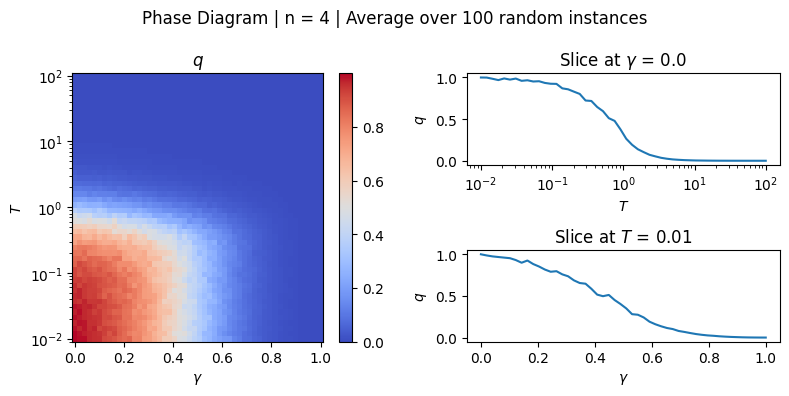

In [9]:
fig, axs = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']],
                              figsize=(8, 4),
                              width_ratios=[2,2])
fig.suptitle(f'Phase Diagram | n = {n} | Average over {num_random_models} random instances')

pc = axs['left'].pcolor(gamma_range, 
                        T_range, 
                        q_avg,
                        cmap='coolwarm')
fig.colorbar(pc, ax=axs['left'])
axs['left'].set_xlabel('$\gamma$')
axs['left'].set_ylabel('$T$')
axs['left'].set_yscale('log')
axs['left'].set_title('$q$')

axs['upper right'].plot(T_range, q_avg[:,0])
axs['upper right'].set_xlabel('$T$')
axs['upper right'].set_xscale('log')
axs['upper right'].set_ylabel('$q$')
axs['upper right'].set_title(f'Slice at $\gamma$ = {gamma_range[0]}')

axs['lower right'].plot(gamma_range, q_avg[1,:])
axs['lower right'].set_xlabel('$\gamma$')
axs['lower right'].set_ylabel('$q$')
axs['lower right'].set_title(f'Slice at $T$ = {T_range[1].round(2)}')

fig.tight_layout()